In [1]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from scipy.linalg import sqrtm
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision.datasets import MNIST, CIFAR10
import sys
from tqdm import tqdm
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import copy
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
N_large = 400
N_small = 100
penalty = 10
mu = 1.0
var = 2.0
N_T = 1
T = 1
eps = 0.01
width = 0.15
gap = 0.05
train_size = 300
MCsample = 500
sigma = 1e-1
# top = [1,3,5]
# print(L)

In [3]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Identity()
resnet18.eval()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
transform_train = transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
	])

transform_test = transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
	])

# CIFAR10 dataset (images and labels)
# Train set
train_dataset = torchvision.datasets.CIFAR10(root='data/', 
                                           train=True, 
                                           transform=transform_train,
                                           download=True)
# Test set
test_dataset = torchvision.datasets.CIFAR10(root='data/', 
                                          train=False,
                                          transform=transform_test,
                                          download=True)

# Function to filter the dataset
def filter_dataset(dataset, labels=(0,)):
    mask = [label in labels for label in dataset.targets]
    indices = torch.nonzero(torch.tensor(mask)).squeeze()
    new_dataset = copy.deepcopy(dataset)
    data = torch.tensor(dataset.data)
    targets = torch.tensor(dataset.targets)
    new_dataset.data = data[indices].numpy()
    new_dataset.targets = targets[indices].numpy()
    return new_dataset

# Filter the training and test datasets
train_dataset_filtered_0 = filter_dataset(train_dataset, (0,))
train_dataset_filtered_1 = filter_dataset(train_dataset, (1,))
test_dataset_filtered_0 = filter_dataset(test_dataset, (0,))
test_dataset_filtered_1 = filter_dataset(test_dataset, (1,))

# Define a function to randomly sample a subset of the dataset
def random_sample(dataset, sample_size):
    indices = torch.randperm(len(dataset))[:sample_size]
    return Subset(dataset, indices)

# Get random samples
P_0 = random_sample(test_dataset_filtered_0, sample_size=1000)
P_1 = random_sample(test_dataset_filtered_1, sample_size=1000)

# print(len(P_0), len(P_1))

combined_dataset = ConcatDataset([P_0, P_1])

# Create a DataLoader to iterate through the sampled dataset
P_loader = DataLoader(combined_dataset, batch_size=len(combined_dataset), shuffle=True)

# Function to split dataset into X and y
def split_dataset_to_xy(loader):
    for data in loader:
        images, labels = data
        return images, labels

# Split the sampled dataset into X and y
P_x, P_y = split_dataset_to_xy(P_loader)

P_x = resnet18(P_x)

P_x = P_x.view(P_x.size()[0], -1)

P_x = P_x.to(device)
P_y = P_y.to(device)
print(P_x.size(), P_y.size())
# print(torch.norm(P_x[2700]))


100%|██████████| 170498071/170498071 [00:15<00:00, 10866854.61it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
torch.Size([2000, 512]) torch.Size([2000])


In [5]:
class dataset:
    def __init__(self, X, y, test_err, post_predict, score, test_acc, label_ratio, noise_ratio):
        self.X = X
        self.y = y
        self.test_err = test_err
        self.post_predict = post_predict
        self.score = score
        self.test_acc = test_acc
        self.label_ratio = label_ratio
        self.noise_ratio = noise_ratio

class result:
    def __init__(self, score_loss, score_acc, err_loss, err_acc, post_predict_loss, post_predict_acc, acc_loss, acc_acc):
        self.score_loss = score_loss
        self.score_acc = score_acc
        self.err_loss = err_loss
        self.err_acc = err_acc
        self.post_predict_loss = post_predict_loss
        self.post_predict_acc = post_predict_acc
        self.acc_loss = acc_loss
        self.acc_acc = acc_acc

    def add(self, another):        
        self.score_loss += another.score_loss
        self.score_acc += another.score_acc
        self.err_loss += another.err_loss
        self.err_acc += another.err_acc
        self.post_predict_loss += another.post_predict_loss
        self.post_predict_acc += another.post_predict_acc
        self.acc_loss += another.acc_loss
        self.acc_acc += another.acc_acc

    def divide(self, num):        
        self.score_loss = self.score_loss / num
        self.score_acc = self.score_acc / num
        self.err_loss = self.err_loss / num
        self.err_acc = self.err_acc / num
        self.post_predict_loss = self.post_predict_loss / num
        self.post_predict_acc = self.post_predict_acc / num
        self.acc_loss =  self.acc_loss / num
        self.acc_acc = self.acc_acc / num

    def getacc(self):
        return [self.score_acc, self.acc_acc, self.post_predict_acc, self.err_acc]
    
    def getloss(self):
        return [self.score_loss, self.acc_loss, self.post_predict_loss, self.err_loss]

#    def self_print(self, num):
#        print("score: ", self.score_loss/num, self.score_acc/num, "\nlog loss:", self.err_loss/num, self.err_acc/num, "\naccuracy:", self.acc_loss/num, self.acc_acc/num)


class summary:
    def __init__(self, percentage_loss_err, percentage_loss_acc, percentage_acc_err, percentage_acc_acc, total_result):
        self.percentage_loss_err = percentage_loss_err
        self.percentage_loss_acc = percentage_loss_acc
        self.percentage_acc_err = percentage_acc_err
        self.percentage_acc_acc = percentage_acc_acc
        self.total_result = total_result
        
    def add(self, another):
        self.percentage_loss_err = np.add(self.percentage_loss_err, another.percentage_loss_err)
        self.percentage_loss_acc = np.add(self.percentage_loss_acc, another.percentage_loss_acc)
        self.percentage_acc_err = np.add(self.percentage_acc_err, another.percentage_acc_err)
        self.percentage_acc_acc = np.add(self.percentage_acc_acc, another.percentage_acc_acc)
        self.total_result.add(another.total_result)
        
    def divide(self, num):
        self.percentage_loss_err = self.percentage_loss_err / num
        self.percentage_loss_acc = self.percentage_loss_acc / num 
        self.percentage_acc_err = self.percentage_acc_err / num 
        self.percentage_acc_acc = self.percentage_acc_acc / num
        self.total_result.divide(num)

    def getacc(self):
        return self.total_result.getacc()

    def getloss(self):
        return self.total_result.getloss()
#    def self_print_percentage(self, num):
#        print(self.percentage_loss_err/num, self.percentage_loss_acc/num, self.percentage_acc_err/num, self.percentage_acc_acc/num)

#    def self_print_result(self, num):
#        self.total_result.self_print(num)

In [6]:
def sigmoid(z):
    return 1/(1 + torch.exp(-z))

def generate_data_cifar10(num, noise, dataset, label):
    sample_set = random_sample(dataset, sample_size=num)
    sample_set_loader = DataLoader(sample_set, batch_size=len(sample_set), shuffle=True)
    X, _ = split_dataset_to_xy(sample_set_loader)
    X = resnet18(X)
    X = X.view(X.size()[0], -1)
    y = torch.ones(num) * label
    y = torch.tensor(y, dtype=torch.int)
    X = X.to(device)
    y = y.to(device)
    for i in range(num):
        flip = torch.bernoulli(torch.tensor(noise)).item()
        if flip == 1:
            y[i] = 1 - y[i]
    return X, y

def generate_dataset_cifar10(N, noise):
    not_found = True
    while not_found:
        N_0 = random.randint(1,N-1)
        X0, y0 = generate_data_cifar10(N_0, noise, train_dataset_filtered_0, 0)
        X1, y1 = generate_data_cifar10(N-N_0, noise, train_dataset_filtered_1, 1)

        X = torch.concatenate((X0, X1), axis = 0)
        y = torch.concatenate((y0, y1), axis = 0)
        if torch.sum(y)>0 and torch.sum(y)<N:
            not_found = False
    return N_0/N, X, y

def generate_train_cifar10(train_size, train_number):
    train_dataset = []
    for i in range(train_number):
        noise_level = random.randint(1, 30)
        # noise_level = 0
        label_ratio, train_X, train_y = generate_dataset_cifar10(train_size, eps * noise_level)
        train_dataset.append(dataset(train_X, train_y, 0, 0, 0, 0, label_ratio, noise_level * eps))
    return train_dataset

def subsample(X, y, size):
    perm = torch.randperm(len(y))
    sample_X = X[perm[:size]]
    sample_y = y[perm[:size]]
    return sample_X, sample_y

def compute_hessian(mu, X):
    m = X.size()[1]
    res = torch.eye(m)
    res = res.to(device)
    for i in range(X.size()[0]):
        xi = X[i:i+1, :]
        sigm = sigmoid(torch.dot(xi[0], mu[0]))
        res += torch.matmul(xi.t(), xi) * (sigm * (1 - sigm)).item()
    return res

def compute_score(mu0, Q0, lg0, mu1, Q1, lg1, mu2, Q2, lg2):
    Q = Q1 + Q2 - Q0
    Q_inv = torch.inverse(Q)
    mu = torch.matmul(Q_inv, torch.matmul(Q1, mu1) + torch.matmul(Q2, mu2) - torch.matmul(Q0, mu0))

    Q_numpy = Q.detach().cpu().numpy()
    eigenvalue, _ = np.linalg.eigh(Q_numpy)
    eigenvalue = torch.tensor(eigenvalue)
    lg12 = torch.sum(torch.log(eigenvalue))

    lg = lg1+lg2-lg12-lg0

    sqr = torch.matmul(mu.T, torch.matmul(Q, mu)) - torch.matmul(mu1.T, torch.matmul(Q1, mu1)) - torch.matmul(mu2.T, torch.matmul(Q2, mu2)) + torch.matmul(mu0.T, torch.matmul(Q0, mu0))

    score = 0.5 * (lg + sqr)
    # print(lg.item(), sqr.item())
    
    return score.item()

def compute_data_score_err(mu_test, Q_test, test_X, test_y, train_X, train_y, lg2):
    test_N = test_y.size()[0]
    M = test_X.size()[1]

    mu0 = torch.zeros((1, M))
    mu0 = mu0.to(device)
    Q0 = torch.eye(M)/penalty
    Q0 = Q0.to(device)
    lg0 = -M * torch.log(torch.tensor(penalty))
    
    train = LogisticRegression(fit_intercept = False, C = penalty, max_iter=5000).fit(train_X.cpu(), train_y.cpu())
    mu_train = torch.tensor(train.coef_, dtype=torch.float32, device=device)
    mu_train_numpy = mu_train.detach().squeeze().cpu().numpy()
    Q_train = compute_hessian(mu_train, train_X)
    Q_train_inverse = torch.inverse(Q_train)
    Q_numpy = Q_train_inverse.detach().cpu().numpy()
    Q_train_numpy = Q_train.detach().cpu().numpy()
    eigenvalue, _ = np.linalg.eigh(Q_train_numpy)
    eigenvalue = torch.tensor(eigenvalue)
    lg1 = torch.sum(torch.log(eigenvalue))
    score = compute_score(mu0.t(), Q0, lg0, mu_train.t(), Q_train, lg1, mu_test.t(), Q_test, lg2)

    log_loss = torch.zeros(test_N)
    log_loss = log_loss.to(device)
    pred = torch.tensor(train.predict_proba(test_X.cpu()), dtype=torch.float32, device=device)
    
    for j in range(test_N):
        a = test_y[j]
        b = pred[j,1]
#        print(a,b)
        log_loss[j] = a * torch.log(b) + (1 - a) * torch.log(1 - b)
        
    test_err = torch.sum(log_loss)/test_N
    test_acc = train.score(test_X.cpu(), test_y.cpu())

    # mvn = torch.distributions.MultivariateNormal(mu_train, Q_train_inverse)
    # theta_samples = mvn.sample((MCsample, ))
    # print(mu_train_numpy.shape)
    Q_numpy = sigma * np.eye(M)
    theta_samples = np.random.multivariate_normal(mu_train_numpy, Q_numpy, MCsample, 'warn')
    theta_samples = torch.tensor(theta_samples).to(device)
    theta_samples = theta_samples.float()

    z = 2 * test_y - 1
    z = z.view(-1,1)
    # print(z.view(-1, 1) * torch.matmul(test_X, theta_samples.t()))
    post_predict = (1 / MCsample) * torch.sum(torch.prod(sigmoid(z.view(-1, 1) * torch.matmul(test_X, theta_samples.t())), dim=0))

    # print(post_predict)
    # sys.exit()
    
    return score, test_err.item(), test_acc, post_predict.item()

def get_err_score(train_data, test_X, test_y, train_number):
    test = LogisticRegression(fit_intercept = False, C = penalty, max_iter=5000).fit(test_X.cpu(), test_y.cpu())
    mu_test = torch.tensor(test.coef_, dtype=torch.float32, device=device)
    Q_test = compute_hessian(mu_test, test_X)
    Q_test_numpy = Q_test.detach().cpu().numpy()
    eigenvalue, _ = np.linalg.eigh(Q_test_numpy)
    eigenvalue = torch.tensor(eigenvalue)
    lg2 = torch.sum(torch.log(eigenvalue))
    for i in range(train_number):
        train_data[i].score, train_data[i].test_err, train_data[i].test_acc, train_data[i].post_predict = compute_data_score_err(mu_test, Q_test, test_X, test_y, train_data[i].X, train_data[i].y, lg2)

def compute_data_err_acc(test_X, test_y, train_X, train_y):
    test_N = test_y.size()[0]
    
    train = LogisticRegression(fit_intercept = False, C = penalty, max_iter=5000).fit(train_X.cpu(), train_y.cpu())
    mu_train = torch.tensor(train.coef_, dtype=torch.float32, device=device)
    mu_train_numpy = mu_train.detach().squeeze().cpu().numpy()
    Q_train = compute_hessian(mu_train, train_X)
    Q_train_inverse = torch.inverse(Q_train)
    Q_numpy = Q_train_inverse.detach().cpu().numpy()

    log_loss = torch.zeros(test_N)
    log_loss = log_loss.to(device)
    pred = torch.tensor(train.predict_proba(test_X.cpu()), dtype=torch.float32, device=device)
    
    for j in range(test_N):
        a = test_y[j]
        b = pred[j,1]
#        print(a,b)
        log_loss[j] = a * torch.log(b) + (1 - a) * torch.log(1 - b)
        
    test_err = torch.sum(log_loss)/test_N
    test_acc = train.score(test_X.cpu(), test_y.cpu())

    theta_samples = np.random.multivariate_normal(mu_train_numpy, Q_numpy, MCsample, 'warn')
    theta_samples = torch.tensor(theta_samples).to(device)
    theta_samples = theta_samples.float()

    # z = 2 * test_y - 1
    # z = z.view(-1,1)
    # print(z.view(-1, 1) * torch.matmul(test_X, theta_samples.t()))
    post_predict = (1 / MCsample) * torch.sum(sigmoid(torch.matmul(test_X, theta_samples.t())), dim=1)

    criterion = nn.BCELoss()
    loss = criterion(post_predict, test_y.float())
    predicted = (post_predict > 0.5).float()
    accuracy = (predicted == test_y.float()).float().mean()

    # print(post_predict)
    # sys.exit()
    return test_err.item(), test_acc, loss.item(), accuracy

In [7]:
@torch.no_grad()
def run(test_size, train_number, top_N):
    # print("\n\ntest size =", test_size, "# of training sets =", train_number, "select top", top_N)
    # summaries = []
    label_ratio = np.zeros(4)
    noise_ratio = np.zeros(4)
    total = summary([0,0], [0,0], [0,0], [0,0], result(0,0,0,0,0,0,0,0))
    single_total = summary([0,0], [0,0], [0,0], [0,0], result(0,0,0,0,0,0,0,0))
    for t in tqdm(range(N_T)):
        # s_L = random.randint(1, (N_total/50) - 1)
        # N_large = s_L * 50
        # N_small = N_total - N_large
        # print(N_large, N_small)
        test_X = P_x
        test_y = P_y
        # test = LogisticRegression(fit_intercept = False, C = penalty, max_iter=5000).fit(test_X.cpu(), test_y.cpu())
        # acc = test.score(test_X.cpu(), test_y.cpu())
        # print(acc)
        # sys.exit()

        train_data = generate_train_cifar10(train_size, train_number)

        results = []
        single_results = []
        total_result = result(0,0,0,0,0,0,0,0)
        single_total_result = result(0,0,0,0,0,0,0,0)
        for i in range(T):
            not_found = True
            while not_found:
                sample_test_X, sample_test_y = subsample(test_X, test_y, test_size)
#                print(sample_test_X, sample_test_y)
                if torch.sum(sample_test_y)>0 and torch.sum(sample_test_y)<test_size:
                    not_found = False
            
            get_err_score(train_data, sample_test_X, sample_test_y, train_number)
            sorted_score = sorted(train_data, key=lambda x: x.score, reverse = True)
            sorted_err = sorted(train_data, key=lambda x: x.test_err, reverse = True)
            sorted_post_predict = sorted(train_data, key=lambda x: x.post_predict, reverse = True)
            sorted_acc = sorted(train_data, key=lambda x: x.test_acc, reverse = True)

            score_X = sorted_score[0].X
            score_y = sorted_score[0].y
            err_X = sorted_err[0].X
            err_y = sorted_err[0].y
            post_predict_X = sorted_post_predict[0].X
            post_predict_y = sorted_post_predict[0].y
            acc_X = sorted_acc[0].X
            acc_y = sorted_acc[0].y

            label_ratio[0] += sorted_score[0].label_ratio
            label_ratio[1] += sorted_acc[0].label_ratio
            label_ratio[2] += sorted_post_predict[0].label_ratio
            label_ratio[3] += sorted_err[0].label_ratio
            noise_ratio[0] += sorted_score[0].noise_ratio
            noise_ratio[1] += sorted_acc[0].noise_ratio
            noise_ratio[2] += sorted_post_predict[0].noise_ratio
            noise_ratio[3] += sorted_err[0].noise_ratio
            
            
    #        print(sorted_acc[0].test_acc, sorted_err[0].test_err)

            for j in range(1, top_N):
    #        print(sorted_err[j].score, sorted_err[j].test_err)
                score_X = torch.concatenate((score_X, sorted_score[j].X), axis = 0)
                score_y = torch.concatenate((score_y, sorted_score[j].y), axis = 0)
                err_X = torch.concatenate((err_X, sorted_err[j].X), axis = 0)
                err_y = torch.concatenate((err_y, sorted_err[j].y), axis = 0)
                post_predict_X = torch.concatenate((post_predict_X, sorted_post_predict[j].X), axis = 0)
                post_predict_y = torch.concatenate((post_predict_y, sorted_post_predict[j].y), axis = 0)
                acc_X = torch.concatenate((acc_X, sorted_acc[j].X), axis = 0)
                acc_y = torch.concatenate((acc_y, sorted_acc[j].y), axis = 0)
    #            print(sorted_acc[j].test_acc, sorted_err[j].test_err)
                label_ratio[0] += sorted_score[j].label_ratio
                label_ratio[1] += sorted_acc[j].label_ratio
                label_ratio[2] += sorted_post_predict[j].label_ratio
                label_ratio[3] += sorted_err[j].label_ratio
                noise_ratio[0] += sorted_score[j].noise_ratio
                noise_ratio[1] += sorted_acc[j].noise_ratio
                noise_ratio[2] += sorted_post_predict[j].noise_ratio
                noise_ratio[3] += sorted_err[j].noise_ratio

            single_score_loss, single_score_acc, score_loss, score_acc = compute_data_err_acc(test_X, test_y, torch.tensor(score_X), torch.tensor(score_y))
            single_err_loss, single_err_acc, err_loss, err_acc = compute_data_err_acc(test_X, test_y, torch.tensor(err_X), torch.tensor(err_y))
            single_post_predict_loss, single_post_predict_acc, post_predict_loss, post_predict_acc = compute_data_err_acc(test_X, test_y, torch.tensor(post_predict_X), torch.tensor(post_predict_y))
            single_acc_loss, single_acc_acc, acc_loss, acc_acc = compute_data_err_acc(test_X, test_y, torch.tensor(acc_X), torch.tensor(acc_y))

            resi = result(score_loss, score_acc, err_loss, err_acc, post_predict_loss, post_predict_acc, acc_loss, acc_acc)
            single_resi = result(single_score_loss, single_score_acc, single_err_loss, single_err_acc, single_post_predict_loss, single_post_predict_acc, single_acc_loss, single_acc_acc)
            results.append(resi)
            single_results.append(single_resi)
            total_result.add(resi)
            single_total_result.add(single_resi)

        # results = sorted(results, key=lambda x: x.diff)

        # err_results = []
        # score_results = []
        total_result.divide(T)
        single_total_result.divide(T)
        summ = summary([0, 0], [0, 0], [0, 0], [0, 0], total_result)
        single_summ = summary([0, 0], [0, 0], [0, 0], [0, 0], single_total_result)
        for i in range(T):
            #err_results.append(results[i].err_result)
            #score_results.append(results[i].score_result)
            #if results[i].diff >= 0 and percentage == -1:
            #    percentage = i
            if results[i].err_loss >= results[i].score_loss:
                summ.percentage_loss_err[1] += 1/T*100
                #percentage_loss_err[1] = percentage_loss_err[1] + 1
            if results[i].err_loss > results[i].score_loss:
                summ.percentage_loss_err[0] += 1/T*100
                #percentage_loss_err[0] = percentage_loss_err[0] + 1
            if results[i].post_predict_acc >= results[i].score_acc:
                summ.percentage_loss_acc[1] += 1/T*100
            if results[i].post_predict_acc > results[i].score_acc:
                summ.percentage_loss_acc[0] += 1/T*100
            if results[i].err_acc >= results[i].score_acc:
                summ.percentage_acc_err[1] += 1/T*100
            if results[i].err_acc > results[i].score_acc:
                summ.percentage_acc_err[0] += 1/T*100
            if results[i].err_acc >= results[i].post_predict_acc:
                summ.percentage_acc_acc[1] += 1/T*100
            if results[i].err_acc > results[i].post_predict_acc:
                summ.percentage_acc_acc[0] += 1/T*100


            if single_results[i].err_loss >= single_results[i].score_loss:
                single_summ.percentage_loss_err[1] += 1/T*100
                #percentage_loss_err[1] = percentage_loss_err[1] + 1
            if single_results[i].err_loss > single_results[i].score_loss:
                single_summ.percentage_loss_err[0] += 1/T*100
                #percentage_loss_err[0] = percentage_loss_err[0] + 1
            if single_results[i].post_predict_acc >= single_results[i].score_acc:
                single_summ.percentage_loss_acc[1] += 1/T*100
            if single_results[i].post_predict_acc > single_results[i].score_acc:
                single_summ.percentage_loss_acc[0] += 1/T*100
            if single_results[i].err_acc >= single_results[i].score_acc:
                single_summ.percentage_acc_err[1] += 1/T*100
            if single_results[i].err_acc > single_results[i].score_acc:
                single_summ.percentage_acc_err[0] += 1/T*100
            if single_results[i].err_acc >= single_results[i].post_predict_acc:
                single_summ.percentage_acc_acc[1] += 1/T*100
            if single_results[i].err_acc > single_results[i].post_predict_acc:
                single_summ.percentage_acc_acc[0] += 1/T*100

        # summaries.append(summ)
        total.add(summ)
        single_total.add(single_summ)
        
    #print("\nAverage percentage over", N_T, "runs: ")
    #total.self_print_percentage(N_T)
    #print("\nAverage accuracy and log loss over", N_T, "*", T, "runs: ")
    #total.self_print_result(N_T)
    total.divide(N_T)
    single_total.divide(N_T)
    label_ratio = label_ratio / N_T
    noise_ratio = noise_ratio / N_T
    label_ratio = label_ratio / top_N
    noise_ratio = noise_ratio / top_N
    label_ratio = label_ratio / T
    noise_ratio = noise_ratio / T
    print("noise_ratio: " +  "{:.4f}".format(noise_ratio[0]) + " & " + "{:.4f}".format(noise_ratio[2]) + " & " + "{:.4f}".format(noise_ratio[3]) + " & " + "{:.4f}".format(noise_ratio[1]))
    print("label_ratio: " +  "{:.4f}".format(label_ratio[0]) + " & " + "{:.4f}".format(label_ratio[2]) + " & " + "{:.4f}".format(label_ratio[3]) + " & " + "{:.4f}".format(label_ratio[1]))
    return total.getacc(), total.getloss(), total.percentage_acc_acc, total.percentage_loss_acc, total.percentage_acc_err, single_total.getacc(), single_total.getloss(), single_total.percentage_acc_acc, single_total.percentage_loss_acc, single_total.percentage_acc_err
    


\hline


100%|██████████| 1/1 [06:38<00:00, 398.74s/it]


noise_ratio: 0.0100 & 0.0100 & 0.0600 & 0.0100
label_ratio: 0.6033 & 0.6033 & 0.8967 & 0.6033
& $1, 30, 200$ & 0.9070 & 0.9070 & 0.7875 & 0.9070 \\ 
Aver. & $1, 30, 200$ & 0.9055 & 0.9070 & 0.7860 & 0.9060 \\ \hline


100%|██████████| 1/1 [12:59<00:00, 779.51s/it]


noise_ratio: 0.0300 & 0.0300 & 0.1200 & 0.1100
label_ratio: 0.9533 & 0.7600 & 0.6333 & 0.4567
& $1, 30, 400$ & 0.7095 & 0.8540 & 0.7265 & 0.8590 \\ 
Aver. & $1, 30, 400$ & 0.7035 & 0.8550 & 0.7270 & 0.8610 \\ \hline


100%|██████████| 1/1 [19:32<00:00, 1172.01s/it]


noise_ratio: 0.0200 & 0.0600 & 0.0100 & 0.0100
label_ratio: 0.0533 & 0.2167 & 0.7367 & 0.5600
& $1, 30, 600$ & 0.7580 & 0.8660 & 0.8510 & 0.8955 \\ 
Aver. & $1, 30, 600$ & 0.7740 & 0.8630 & 0.8545 & 0.8920 \\ \hline
\hline


100%|██████████| 1/1 [06:39<00:00, 399.91s/it]


noise_ratio: 0.0100 & 0.0100 & 0.0200 & 0.0100
label_ratio: 0.6967 & 0.8367 & 0.7633 & 0.8367
& $1, 40, 200$ & 0.8915 & 0.8620 & 0.8730 & 0.8620 \\ 
Aver. & $1, 40, 200$ & 0.8910 & 0.8615 & 0.8730 & 0.8600 \\ \hline


100%|██████████| 1/1 [13:05<00:00, 785.90s/it]


noise_ratio: 0.0100 & 0.0100 & 0.2800 & 0.0100
label_ratio: 0.9233 & 0.7833 & 0.5200 & 0.6633
& $1, 40, 400$ & 0.7915 & 0.8445 & 0.6485 & 0.8805 \\ 
Aver. & $1, 40, 400$ & 0.7970 & 0.8445 & 0.6480 & 0.8820 \\ \hline


100%|██████████| 1/1 [19:16<00:00, 1156.81s/it]


noise_ratio: 0.0100 & 0.0100 & 0.1100 & 0.0100
label_ratio: 0.3167 & 0.3167 & 0.4000 & 0.3167
& $1, 40, 600$ & 0.9040 & 0.9040 & 0.7975 & 0.9040 \\ 
Aver. & $1, 40, 600$ & 0.9050 & 0.9035 & 0.7950 & 0.9035 \\ \hline
\hline


100%|██████████| 1/1 [06:29<00:00, 389.89s/it]


noise_ratio: 0.0100 & 0.0100 & 0.0800 & 0.0100
label_ratio: 0.6133 & 0.6133 & 0.0667 & 0.3567
& $1, 50, 200$ & 0.8875 & 0.8875 & 0.6640 & 0.9000 \\ 
Aver. & $1, 50, 200$ & 0.8830 & 0.8835 & 0.6655 & 0.8990 \\ \hline


100%|██████████| 1/1 [12:46<00:00, 766.29s/it]


noise_ratio: 0.0100 & 0.0100 & 0.0900 & 0.0500
label_ratio: 0.9100 & 0.6100 & 0.1233 & 0.4533
& $1, 50, 400$ & 0.8010 & 0.8840 & 0.7130 & 0.8460 \\ 
Aver. & $1, 50, 400$ & 0.8015 & 0.8865 & 0.7085 & 0.8475 \\ \hline


100%|██████████| 1/1 [19:32<00:00, 1172.40s/it]


noise_ratio: 0.0100 & 0.0100 & 0.0700 & 0.0400
label_ratio: 0.1233 & 0.6100 & 0.2033 & 0.5367
& $1, 50, 600$ & 0.8465 & 0.8760 & 0.7875 & 0.8660 \\ 
Aver. & $1, 50, 600$ & 0.8460 & 0.8690 & 0.7840 & 0.8685 \\ \hline
\hhline{|=|=|=|=|=|=|}


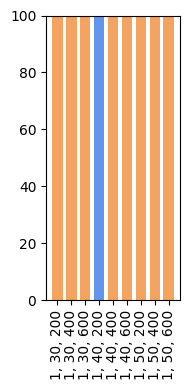

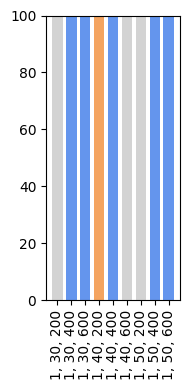

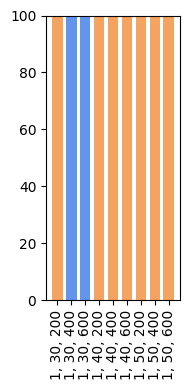

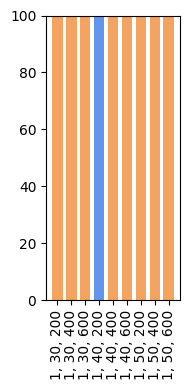

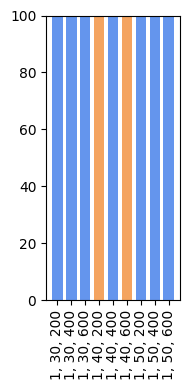

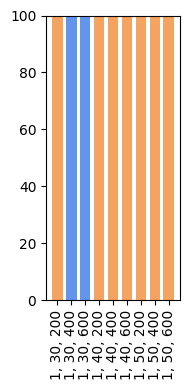

\hline


100%|██████████| 1/1 [06:33<00:00, 393.19s/it]


noise_ratio: 0.0160 & 0.0300 & 0.0860 & 0.0420
label_ratio: 0.4793 & 0.3747 & 0.4120 & 0.4873
& $5, 30, 200$ & 0.8970 & 0.8705 & 0.8075 & 0.8485 \\ 
Aver. & $5, 30, 200$ & 0.9005 & 0.8695 & 0.8065 & 0.8475 \\ \hline


100%|██████████| 1/1 [12:55<00:00, 775.00s/it]


noise_ratio: 0.0200 & 0.0280 & 0.1360 & 0.0600
label_ratio: 0.1540 & 0.3133 & 0.4020 & 0.3313
& $5, 30, 400$ & 0.8670 & 0.8680 & 0.7505 & 0.8095 \\ 
Aver. & $5, 30, 400$ & 0.8645 & 0.8690 & 0.7515 & 0.8085 \\ \hline


100%|██████████| 1/1 [19:21<00:00, 1161.61s/it]


noise_ratio: 0.0200 & 0.0600 & 0.0840 & 0.0380
label_ratio: 0.3813 & 0.4293 & 0.4707 & 0.5500
& $5, 30, 600$ & 0.9075 & 0.8290 & 0.8015 & 0.8240 \\ 
Aver. & $5, 30, 600$ & 0.9065 & 0.8265 & 0.8020 & 0.8245 \\ \hline
\hline


100%|██████████| 1/1 [06:32<00:00, 392.60s/it]


noise_ratio: 0.0180 & 0.0300 & 0.1460 & 0.0260
label_ratio: 0.5047 & 0.6060 & 0.6333 & 0.6160
& $5, 40, 200$ & 0.8800 & 0.8590 & 0.7405 & 0.8615 \\ 
Aver. & $5, 40, 200$ & 0.8800 & 0.8580 & 0.7430 & 0.8595 \\ \hline


100%|██████████| 1/1 [12:54<00:00, 774.49s/it]


noise_ratio: 0.0140 & 0.0960 & 0.0840 & 0.0460
label_ratio: 0.0920 & 0.4207 & 0.2873 & 0.3340
& $5, 40, 400$ & 0.8550 & 0.7900 & 0.7935 & 0.8585 \\ 
Aver. & $5, 40, 400$ & 0.8555 & 0.7900 & 0.7925 & 0.8600 \\ \hline


100%|██████████| 1/1 [19:14<00:00, 1154.40s/it]


noise_ratio: 0.0100 & 0.0500 & 0.1100 & 0.0760
label_ratio: 0.5193 & 0.4053 & 0.3827 & 0.5540
& $5, 40, 600$ & 0.8960 & 0.8335 & 0.7875 & 0.8105 \\ 
Aver. & $5, 40, 600$ & 0.8950 & 0.8340 & 0.7890 & 0.8080 \\ \hline
\hline


100%|██████████| 1/1 [06:34<00:00, 394.40s/it]


noise_ratio: 0.0180 & 0.0240 & 0.1680 & 0.0460
label_ratio: 0.7607 & 0.5807 & 0.4307 & 0.5300
& $5, 50, 200$ & 0.8600 & 0.8900 & 0.7425 & 0.8420 \\ 
Aver. & $5, 50, 200$ & 0.8590 & 0.8900 & 0.7395 & 0.8435 \\ \hline


100%|██████████| 1/1 [12:56<00:00, 776.00s/it]


noise_ratio: 0.0240 & 0.0360 & 0.1240 & 0.0400
label_ratio: 0.4033 & 0.3947 & 0.2787 & 0.3713
& $5, 50, 400$ & 0.8835 & 0.8695 & 0.7595 & 0.8530 \\ 
Aver. & $5, 50, 400$ & 0.8840 & 0.8705 & 0.7600 & 0.8535 \\ \hline


100%|██████████| 1/1 [19:13<00:00, 1153.30s/it]


noise_ratio: 0.0120 & 0.0460 & 0.1140 & 0.0400
label_ratio: 0.8593 & 0.5300 & 0.4447 & 0.6227
& $5, 50, 600$ & 0.8825 & 0.8560 & 0.7965 & 0.8610 \\ 
Aver. & $5, 50, 600$ & 0.8830 & 0.8565 & 0.7975 & 0.8620 \\ \hline
\hhline{|=|=|=|=|=|=|}


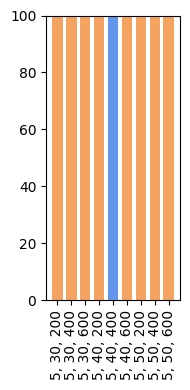

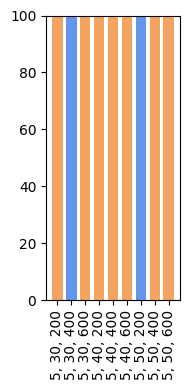

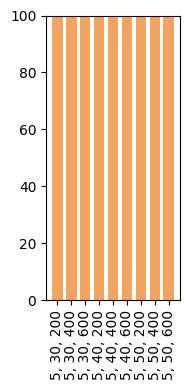

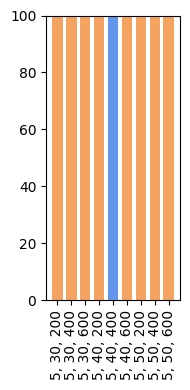

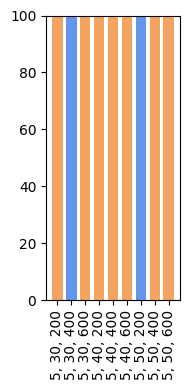

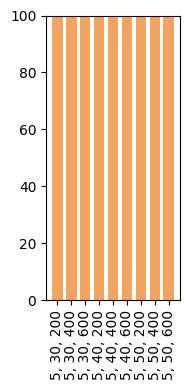

\hline


100%|██████████| 1/1 [06:31<00:00, 391.86s/it]


noise_ratio: 0.0211 & 0.0644 & 0.0889 & 0.0911
label_ratio: 0.5041 & 0.4522 & 0.4148 & 0.4907
& $9, 30, 200$ & 0.8950 & 0.8650 & 0.8530 & 0.8705 \\ 
Aver. & $9, 30, 200$ & 0.8960 & 0.8665 & 0.8525 & 0.8695 \\ \hline


100%|██████████| 1/1 [13:13<00:00, 793.89s/it]


noise_ratio: 0.0144 & 0.0500 & 0.0889 & 0.0622
label_ratio: 0.3581 & 0.4059 & 0.4678 & 0.4207
& $9, 30, 400$ & 0.8910 & 0.8645 & 0.8475 & 0.8600 \\ 
Aver. & $9, 30, 400$ & 0.8925 & 0.8645 & 0.8460 & 0.8600 \\ \hline


100%|██████████| 1/1 [19:09<00:00, 1149.91s/it]


noise_ratio: 0.0144 & 0.0233 & 0.0822 & 0.0389
label_ratio: 0.5426 & 0.5744 & 0.4344 & 0.4415
& $9, 30, 600$ & 0.8940 & 0.8665 & 0.8550 & 0.8805 \\ 
Aver. & $9, 30, 600$ & 0.8930 & 0.8665 & 0.8540 & 0.8800 \\ \hline
\hline


100%|██████████| 1/1 [06:18<00:00, 378.30s/it]


noise_ratio: 0.0211 & 0.0378 & 0.0678 & 0.0556
label_ratio: 0.3741 & 0.4856 & 0.3404 & 0.4622
& $9, 40, 200$ & 0.8830 & 0.8625 & 0.8450 & 0.8735 \\ 
Aver. & $9, 40, 200$ & 0.8850 & 0.8620 & 0.8425 & 0.8740 \\ \hline


100%|██████████| 1/1 [13:04<00:00, 784.50s/it]


noise_ratio: 0.0167 & 0.0422 & 0.1267 & 0.0389
label_ratio: 0.5270 & 0.4167 & 0.4807 & 0.3848
& $9, 40, 400$ & 0.8745 & 0.8705 & 0.8430 & 0.8715 \\ 
Aver. & $9, 40, 400$ & 0.8775 & 0.8710 & 0.8440 & 0.8710 \\ \hline


100%|██████████| 1/1 [19:11<00:00, 1151.80s/it]


noise_ratio: 0.0167 & 0.0356 & 0.1456 & 0.0522
label_ratio: 0.3896 & 0.5596 & 0.5163 & 0.5167
& $9, 40, 600$ & 0.8855 & 0.8850 & 0.8115 & 0.8835 \\ 
Aver. & $9, 40, 600$ & 0.8850 & 0.8850 & 0.8090 & 0.8840 \\ \hline
\hline


100%|██████████| 1/1 [06:35<00:00, 395.61s/it]


noise_ratio: 0.0222 & 0.1100 & 0.0444 & 0.0567
label_ratio: 0.6456 & 0.4607 & 0.4444 & 0.4019
& $9, 50, 200$ & 0.8945 & 0.8280 & 0.8645 & 0.8650 \\ 
Aver. & $9, 50, 200$ & 0.8950 & 0.8295 & 0.8645 & 0.8650 \\ \hline


100%|██████████| 1/1 [12:58<00:00, 778.11s/it]


noise_ratio: 0.0167 & 0.0378 & 0.1100 & 0.0411
label_ratio: 0.3622 & 0.4567 & 0.6126 & 0.2178
& $9, 50, 400$ & 0.8820 & 0.8715 & 0.8415 & 0.8475 \\ 
Aver. & $9, 50, 400$ & 0.8800 & 0.8715 & 0.8410 & 0.8470 \\ \hline


100%|██████████| 1/1 [19:22<00:00, 1162.50s/it]


noise_ratio: 0.0167 & 0.0500 & 0.1333 & 0.0489
label_ratio: 0.1048 & 0.3970 & 0.4396 & 0.4878
& $9, 50, 600$ & 0.8590 & 0.8830 & 0.8420 & 0.8685 \\ 
Aver. & $9, 50, 600$ & 0.8600 & 0.8815 & 0.8390 & 0.8670 \\ \hline
\hhline{|=|=|=|=|=|=|}


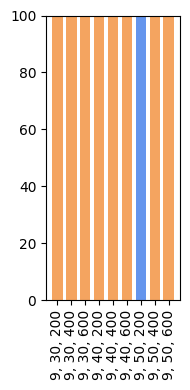

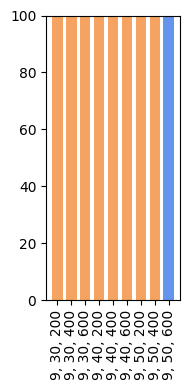

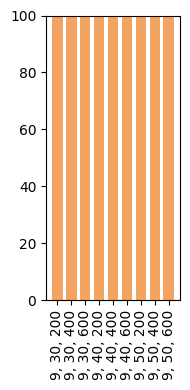

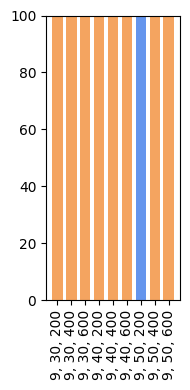

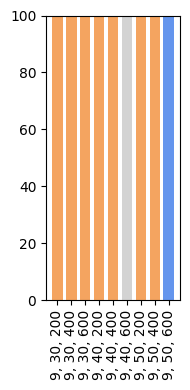

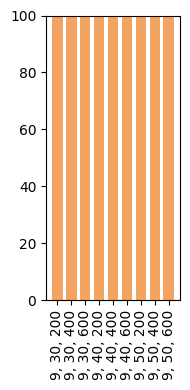

In [8]:
def generate_plot(x_label, a_L, a_H):
#    print(width, gap)
    x = np.array(range(len(x_label))) * (width + gap)
#    print(e_L, e_H)
    acc_L = np.ones(len(x_label))*100 - np.array(a_H) 
    acc_H = np.ones(len(x_label))*100 - np.array(a_L)
    plt.rcParams['figure.figsize'] = [(width + gap) * (len(x_label) + 1), 4]
    plt.bar(x, acc_L, color='sandybrown', width = width)
    plt.bar(x, acc_H - acc_L, bottom= acc_L, color='lightgray', width = width)
    plt.bar(x, np.ones(len(x_label))*100 - acc_H, bottom= acc_H, color='cornflowerblue', width = width)
    plt.xticks(x, x_label, rotation='vertical')
    plt.tight_layout()
    plt.savefig("bar3.pdf", format="pdf", dpi=20) #add legend
    plt.show()

# from pyinstrument import Profiler

# profiler = Profiler()
# profiler.start()
x_label_all = []
err_post_L_all = []
err_post_H_all = []
post_score_L_all = []
post_score_H_all = []
err_score_L_all = []
err_score_H_all = []

single_err_post_L_all = []
single_err_post_H_all = []
single_post_score_L_all = []
single_post_score_H_all = []
single_err_score_L_all = []
single_err_score_H_all = []
acc_all_all = []
single_acc_all_all = []
loss_all_all = []
single_loss_all_all = []

for itr_top in range(1,11,4):
    x_label = []
    err_post_L = []
    err_post_H = []
    post_score_L = []
    post_score_H = []
    err_score_L = []
    err_score_H = []

    single_err_post_L = []
    single_err_post_H = []
    single_post_score_L = []
    single_post_score_H = []
    single_err_score_L = []
    single_err_score_H = []
    acc_all = []
    single_acc_all = []
    loss_all = []
    single_loss_all = []
    for itr_test in range(30, 60, 10):
        print("\\hline")
        for itr_train in range(200, 610, 200):
            # label1 = "K =" + str(itr_top) + ", N_T =" + str(itr_test) + ", M =" + str(itr_train)
            # label2 = "N_T =" + str(itr_test) + ", M =" + str(itr_train)
            label3 = str(itr_top) + ", " + str(itr_test) + ", " + str(itr_train)
            x_label.append(label3)
            acc, loss, percentage_err_post, percentage_post_score, percentage_err_score, single_acc, single_loss, single_percentage_err_post, single_percentage_post_score, single_percentage_err_score = run(itr_test, itr_train, itr_top)
            print("& $"+label3+"$ & " + "{:.4f}".format(single_acc[0]) + " & " + "{:.4f}".format(single_acc[2]) + " & " + "{:.4f}".format(single_acc[3]) +" & " + "{:.4f}".format(single_acc[1]) +" \\\\ " )
            # print("Aver. & $"+label3+"$ & " + "{:.4f}".format(acc[0]) + " & " + "{:.4f}".format(acc[2]) + " & " + "{:.4f}".format(acc[3]) + " & " + "{:.4f}".format(acc[0]-acc[2]) + " & " + "{:.4f}".format(acc[2]-acc[3]) +" \\\\ " )
            print("Aver. & $"+label3+"$ & " + "{:.4f}".format(acc[0]) + " & " + "{:.4f}".format(acc[2]) + " & " + "{:.4f}".format(acc[3]) + " & " + "{:.4f}".format(acc[1]) +" \\\\ " + "\\hline")
            # print("& " + "{:.4f}".format(single_acc[0]-acc[0]) + " & " + "{:.4f}".format(single_acc[2]-acc[2]) + " & " + "{:.4f}".format(single_acc[3]-acc[3]) + " & " )
            err_post_L.append(percentage_err_post[0])
            err_post_H.append(percentage_err_post[1])
            single_err_post_L.append(single_percentage_err_post[0])
            single_err_post_H.append(single_percentage_err_post[1])
            post_score_L.append(percentage_post_score[0])
            post_score_H.append(percentage_post_score[1])
            single_post_score_L.append(single_percentage_post_score[0])
            single_post_score_H.append(single_percentage_post_score[1])
            err_score_L.append(percentage_err_score[0])
            err_score_H.append(percentage_err_score[1])
            single_err_score_L.append(single_percentage_err_score[0])
            single_err_score_H.append(single_percentage_err_score[1])
            acc_all.append(acc)
            single_acc_all.append(acc)
            loss_all.append(loss)
            single_loss_all.append(single_loss)
            # profiler.stop()

            # profiler.print()
            # sys.exit()


    print("\\hhline{|=|=|=|=|=|=|}")

    x_label_all += x_label
    err_post_L_all += err_post_L
    err_post_H_all += err_post_H
    post_score_L_all += post_score_L
    post_score_H_all += post_score_H
    err_score_L_all += err_score_L
    err_score_H_all += err_score_H

    single_err_post_L_all += single_err_post_L
    single_err_post_H_all += single_err_post_H
    single_post_score_L_all += single_post_score_L
    single_post_score_H_all += single_post_score_H
    single_err_score_L_all += single_err_score_L
    single_err_score_H_all += single_err_score_H
    
    acc_all_all += acc_all
    single_acc_all_all += single_acc_all
    loss_all_all += loss_all
    single_loss_all_all += single_loss_all
            
    generate_plot(x_label, single_err_post_L, single_err_post_H)
    generate_plot(x_label, single_post_score_L, single_post_score_H)
    generate_plot(x_label, single_err_score_L, single_err_score_H)
    generate_plot(x_label, err_post_L, err_post_H)
    generate_plot(x_label, post_score_L, post_score_H)
    generate_plot(x_label, err_score_L, err_score_H)



In [9]:
def generate_plot(x_label, a_L, a_H, label1, label2):
#    print(width, gap)
    x = np.array(range(len(x_label))) * (width + gap)
#    print(e_L, e_H)
    acc_L = np.ones(len(x_label))*100 - np.array(a_H) 
    acc_H = np.ones(len(x_label))*100 - np.array(a_L)
    plt.rcParams['figure.figsize'] = [(width + gap) * (len(x_label) + 1), 4]
    plt.bar(x, acc_L, color='sandybrown', width = width, label = label1)
    plt.bar(x, np.ones(len(x_label))*100 - acc_H, bottom= acc_H, color='cornflowerblue', width = width, label = label2)
    plt.bar(x, acc_H - acc_L, bottom= acc_L, color='lightgray', width = width, label = 'Ties')
    plt.xticks(x, x_label, rotation='vertical')
    plt.tight_layout()
    plt.legend(loc=4)
    plt.savefig("bar3.pdf", format="pdf", dpi=20) #add legend
    plt.show()

[[tensor(0.9055, device='cuda:0'), tensor(0.9060, device='cuda:0'), tensor(0.9070, device='cuda:0'), tensor(0.7860, device='cuda:0')], [tensor(0.7035, device='cuda:0'), tensor(0.8610, device='cuda:0'), tensor(0.8550, device='cuda:0'), tensor(0.7270, device='cuda:0')], [tensor(0.7740, device='cuda:0'), tensor(0.8920, device='cuda:0'), tensor(0.8630, device='cuda:0'), tensor(0.8545, device='cuda:0')], [tensor(0.8910, device='cuda:0'), tensor(0.8600, device='cuda:0'), tensor(0.8615, device='cuda:0'), tensor(0.8730, device='cuda:0')], [tensor(0.7970, device='cuda:0'), tensor(0.8820, device='cuda:0'), tensor(0.8445, device='cuda:0'), tensor(0.6480, device='cuda:0')], [tensor(0.9050, device='cuda:0'), tensor(0.9035, device='cuda:0'), tensor(0.9035, device='cuda:0'), tensor(0.7950, device='cuda:0')], [tensor(0.8830, device='cuda:0'), tensor(0.8990, device='cuda:0'), tensor(0.8835, device='cuda:0'), tensor(0.6655, device='cuda:0')], [tensor(0.8015, device='cuda:0'), tensor(0.8475, device='cuda

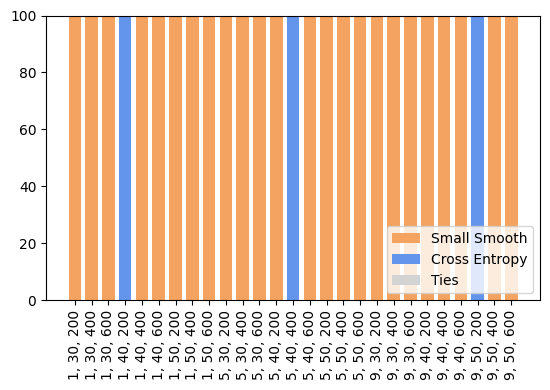

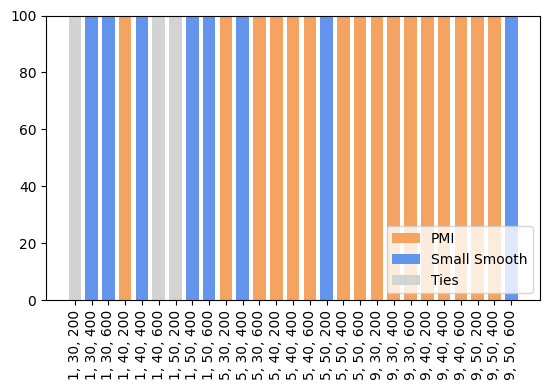

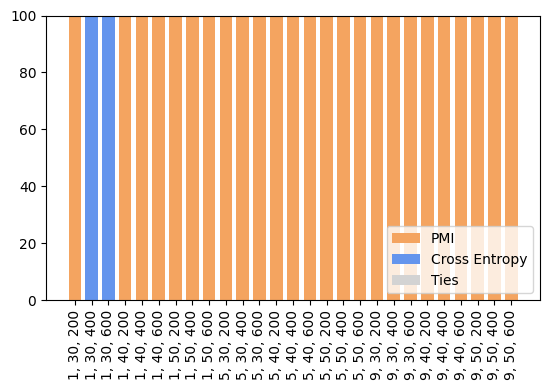

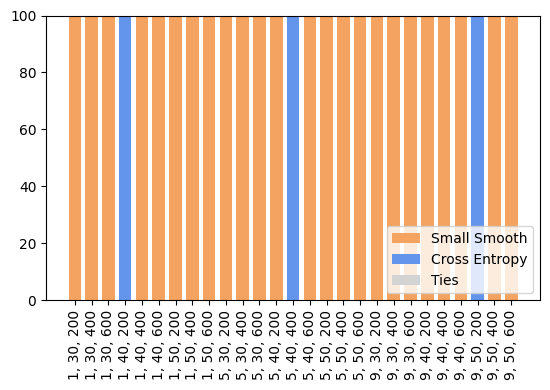

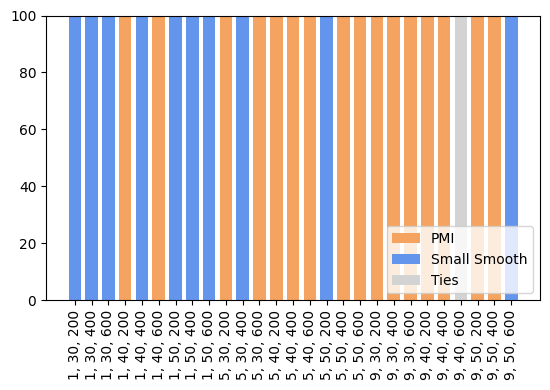

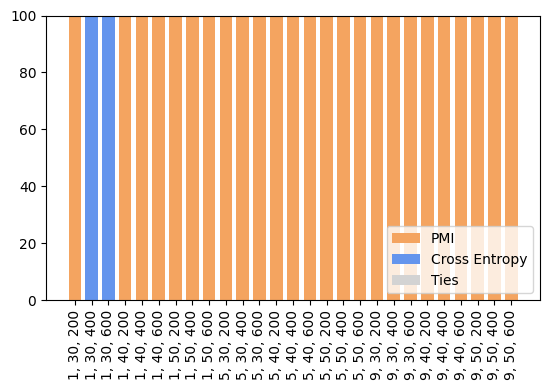

In [10]:
# print(err_post_L_all, err_post_H_all)

# print(len(acc_all_all[0]))
print(single_acc_all_all)
# print(x_label_all)
generate_plot(x_label_all, single_err_post_L_all, single_err_post_H_all, 'Small Smooth', 'Cross Entropy')
generate_plot(x_label_all, single_post_score_L_all, single_post_score_H_all, 'PMI', 'Small Smooth')
generate_plot(x_label_all, single_err_score_L_all, single_err_score_H_all, 'PMI', 'Cross Entropy')
generate_plot(x_label_all, err_post_L_all, err_post_H_all, 'Small Smooth', 'Cross Entropy')
generate_plot(x_label_all, post_score_L_all, post_score_H_all, 'PMI', 'Small Smooth')
generate_plot(x_label_all, err_score_L_all, err_score_H_all, 'PMI', 'Cross Entropy')
            

In [11]:
def generate_loss_plot(x_label, loss):
#    print(width, gap)
    score_loss = []
    acc_loss = []
    post_loss = []
    err_loss = []
    for i in range(27):
        score_loss.append(loss[i][0])
        acc_loss.append(loss[i][1])
        post_loss.append(loss[i][2])
        err_loss.append(loss[i][3])
    x = np.array(range(len(x_label))) * (width*5 + gap*2)
#    print(e_L, e_H)
    
    plt.rcParams['figure.figsize'] = [(width*5 + gap*2) * (len(x_label) + 1), 4]
    plt.bar(x-1.5*width, score_loss, width = width, label = "PMI")
    plt.bar(x-0.5*width, post_loss, width = width, label = "Small Smooth")
    plt.bar(x+0.5*width, err_loss, width = width, label = "Loss")
    plt.bar(x+1.5*width, acc_loss, width = width, label = "Acc")
    plt.xticks(x, x_label, rotation='vertical')
    plt.tight_layout()
    plt.legend(loc=4)
    plt.savefig("bar3.pdf", format="pdf", dpi=20) #add legend
    plt.show()

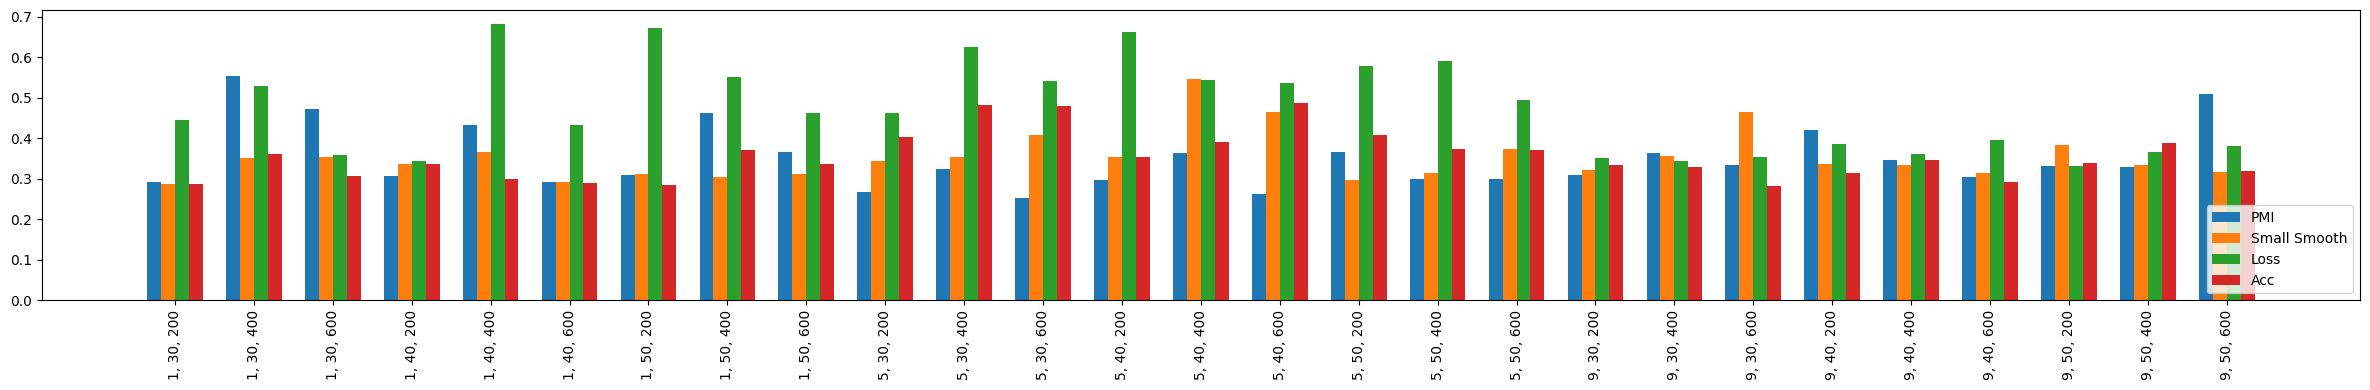

In [12]:
generate_loss_plot(x_label_all, loss_all_all)